# Ranking the drawdowns of Index constituents

It is useful to keep a tab on drawdowns of index constituents to get a feel for how the index is diverging/converging from individual stock performance. For example, 7 stocks account for 50% of the NIFTY 50's performance and end up masking the performance of the other 43. If the rest are crashing, how long will the best hold up?

StockViz has an automated report on drawdowns of NIFTY 100, MIDCAP 150 and SMLCAP 100 constituents that gets generated everyday [here](https://stockviz.github.io/reports/drawdown/drawdowns.html). The [underlying code](https://github.com/stockviz/reports/tree/master/drawdown) is an R-markdown script who's output gets pushed to github. In this notebook, by setting the *indexName* variable to any NSE/NIFTY index that we have constituents for, you can generate the same report for yourself on [pluto](http://pluto.studio).

In [1]:
library(tidyverse)
library(ggthemes)
library(reshape2)
library(odbc)
library(RPostgres)
library(plutoR)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)

options("scipen"=999)
options(stringsAsFactors = FALSE)
options(repr.plot.width=16, repr.plot.height=8)

source("config.R")
source("goofy/plot.common.R")
source("goofy/misc.common.R")

#initialize
indices<-Indices()
equitiesIndiaNse <- EquitiesIndiaNse()

indexName <- "NIFTY 50"

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: TTR
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Version 0.4-0 included new data defaults

In [2]:
maxDt <- (indices$NseConstituents() %>%
          filter(NAME == indexName) %>%
          summarize(MAX_TS = max(TIME_STAMP)) %>% 
          collect())$MAX_TS[1]

constituents <- indices$NseConstituents() %>%
    filter(TIME_STAMP == maxDt & NAME == "NIFTY 50") %>%
    collect() %>%
    as.data.frame()

Warning message:
“Missing values are always removed in SQL.
Use `MAX(x, na.rm = TRUE)` to silence this warning
This warning is displayed only once per session.”

### plot the weights to get a feel for individual contributions

ERROR while rich displaying an object: Error in tapply(X = X, INDEX = x, FUN = FUN, ...): argument "X" is missing, with no default

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](ob

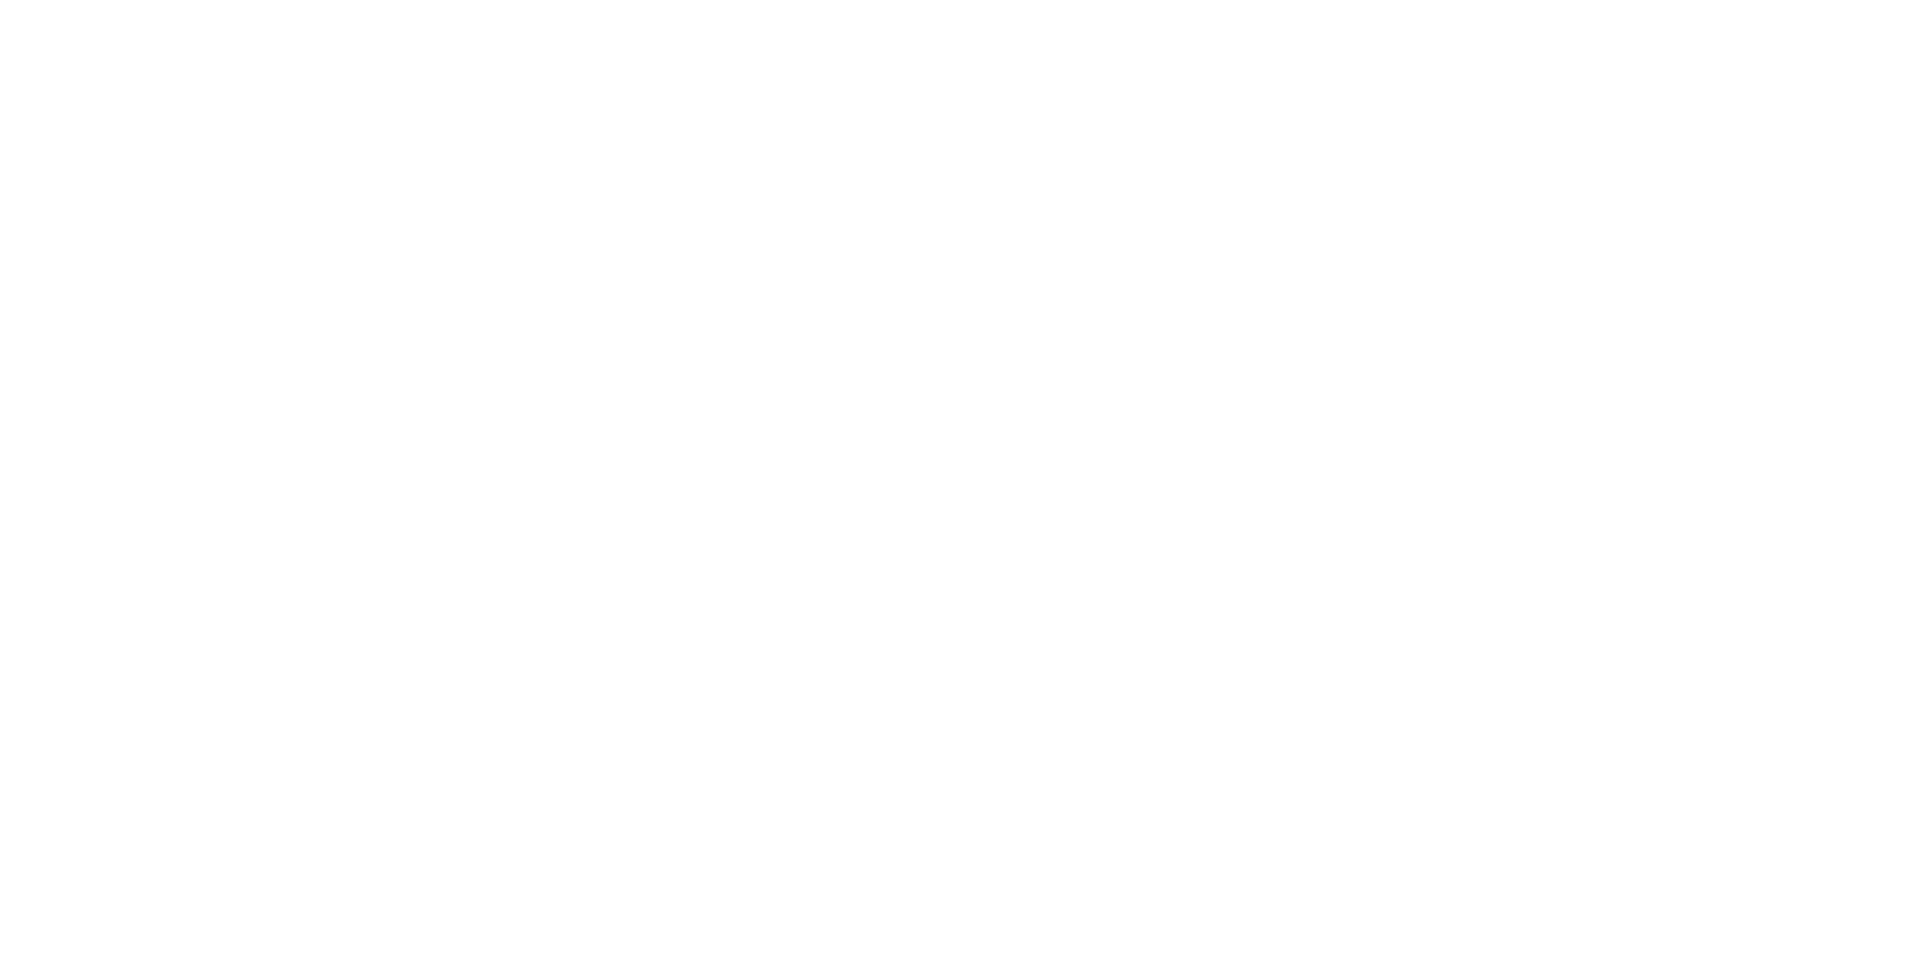

In [3]:
toPlot <- constituents

ggplot(toPlot, aes(x=SYMBOL, y=reorder(-CAP_WEIGHT))) +
    theme_economist() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    geom_bar(stat="identity", position=position_dodge()) +
    geom_text_repel(aes(label=round(CAP_WEIGHT, 2)), position = position_dodge(0.9)) +
    scale_x_discrete() + 
    labs(x='', y='free-float cap weight (%)', color='', fill='', title=sprintf("%s Composition", indexName)) +
    annotate("text", x=nrow(toPlot), y=0, label = "@StockViz", 
             hjust=-1.1, vjust=-1.1, col="white", cex=6, fontface = "bold", alpha = 0.8)